ASL TRANSLATOR
If the data and the model have already been saved run cells #1, #6, #15 and #16

IMPORTS

In [1]:
#1
#All the imports needed for this notebook

import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score
import mediapipe as mp
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGES TO ARRAYS

In [18]:
#2
#Transforming the images to grayscale, then saving them as arrays

#Mapping of the letters based of numbers
index_to_letter = {
    '0': 'A', '1': 'B', '2': 'C', '3': 'D', '5': 'E', '6': 'F', '7': 'G', '8': 'H', 
    '9': 'I', '10': 'J', '11': 'K', '12': 'L', '13': 'M', '14': 'N', '16': 'O', 
    '17': 'P', '18': 'Q', '19': 'R', '20': 'S', '21': 'space', '22': 'T', '23': 'U', '24': 'V', 
    '25': 'W', '26': 'X', '27': 'Y', '28': 'Z'
}

#Function that will load the images, turn them into gray scale, resize it to 128x128 and append them to the data list, 
#as well as appending the label to the label list
def load_images_from_folder(folder_path):
    data = []
    labels = []

    for label_folder in os.listdir(folder_path): #Loop through the folder for each subfolder
        label_path = os.path.join(folder_path, label_folder)
        if not os.path.isdir(label_path):
            continue
        
        for filename in os.listdir(label_path): #Loop through the subfolder for each images
            img_path = os.path.join(label_path, filename)
            if not img_path.endswith(".jpg") and not img_path.endswith(".png"):
                continue
            
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  #Read the image in grayscale
            if img is not None:
                img = cv2.resize(img, (128, 128))  #Resize all images to the same size
                data.append(img) #Append the image
                labels.append(index_to_letter[label_folder]) #Append the label

    data = np.array(data)#Turn the data list into numpy arrays
    labels = np.array(labels)#Turn the label list into a numpy array

    return data, labels

In [19]:
#3
#Loads the data and labels as numpy arrays and print their shapes

folder_path = "D:\\asl_alphabet_train" #The folder path for your data set
data, labels = load_images_from_folder(folder_path) #Use the function defined previously to create two numpy arrays

print("Data shape:", data.shape) #Printing shape of data
print("Labels shape:", labels.shape) #Printing shape of label

#**For data, expeced shape (n, 128, 128), where n is the number of training samples**
#**For labels, expected shape (n,), where n is the number of training samples**

Data shape: (195058, 128, 128)
Labels shape: (195058,)


In [20]:
#4
#Save the data and label array on your machine

np.save('data_2-0.npy', data)
np.save('labels_2-0.npy', labels)

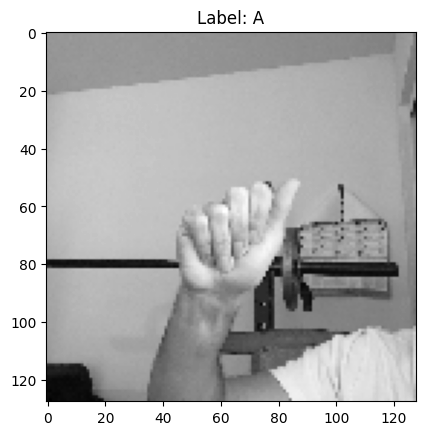

In [32]:
#5
#Show the first image, how it was saved (resized and grayscale)

import matplotlib.pyplot as plt

# Display a sample image and its label
index = 0  # Change this to see different samples
plt.imshow(data[index], cmap='gray')
plt.title(f"Label: {labels[index]}")
plt.show()

TRAINING MODEL

In [2]:
#6
#Load the data, normalize it, encode it, then make your training set and testing set

#Load the data
data = np.load('data_2-0.npy')
labels = np.load('labels_2-0.npy')

#Normalize pixel values to be between 0 and 1
data = data.astype('float32') / 255.0

#Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

#Split data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)

# Add a channel dimension (for grayscale images)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

#Printing training set and test set
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (156046, 128, 128, 1)
X_val shape: (39012, 128, 128, 1)


In [8]:
#7
#Converts from a vector to a matrix

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [9]:
#8
#Transforms the image for data augmentation

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [10]:
#9
#The creation of the convolutional neural network (CNN)

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation='softmax')
])

#Summary of the CNN
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 batch_normalization_5 (Batc  (None, 126, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_6 (Batc  (None, 61, 61, 64)       256       
 hNormalization)                                                 
                                                      

In [11]:
#10
#Compile the model with the Adam optimizer, categorical crossentropy and accuracy metric

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
#11
#The batch size and the number of epochs

batch_size = 32
epochs = 10

In [15]:
#12
#Training the model

model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs
)

Epoch 1/10
4876/4876 [==============================] - 1431s 293ms/step - loss: 1.7664 - accuracy: 0.4708 - val_loss: 0.4574 - val_accuracy: 0.8605
Epoch 2/10
4876/4876 [==============================] - 1421s 291ms/step - loss: 0.7422 - accuracy: 0.7653 - val_loss: 0.3045 - val_accuracy: 0.9133
Epoch 3/10
4876/4876 [==============================] - 1410s 289ms/step - loss: 0.5425 - accuracy: 0.8303 - val_loss: 0.4885 - val_accuracy: 0.8493
Epoch 4/10
4876/4876 [==============================] - 1424s 292ms/step - loss: 0.4419 - accuracy: 0.8618 - val_loss: 0.1405 - val_accuracy: 0.9558
Epoch 5/10
4876/4876 [==============================] - 1424s 292ms/step - loss: 0.3864 - accuracy: 0.8795 - val_loss: 0.1619 - val_accuracy: 0.9490
Epoch 6/10
4876/4876 [==============================] - 1407s 289ms/step - loss: 0.3404 - accuracy: 0.8929 - val_loss: 0.4842 - val_accuracy: 0.8494
Epoch 7/10
4876/4876 [==============================] - 1438s 295ms/step - loss: 0.3091 - accuracy: 0.9027

In [16]:
#14
#Save the model in your machine

model.save('even_better_lang_model.h5')

TESTING MODEL

In [3]:
#15
#Load the model

model = load_model('even_better_lang_model.h5')

In [7]:
#16
#This is the cell for real time testing of the model


#Define initial ROI coordinates and size (adjust as needed)
roi_width = 225  #Width of the ROI box
roi_height = 255 #Height of the ROI box
roi_x = 400  #X-coordinate of the ROI box (adjust as needed, towards the right)
roi_y = 100  #Y-coordinate of the ROI box (adjust as needed, towards the top)

def predict_sign_in_roi(frame, roi):
    #Extract ROI
    roi_frame = frame[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]]
    #Preprocess the ROI
    img = cv2.cvtColor(roi_frame, cv2.COLOR_BGR2GRAY)  #Convert ROI to grayscale
    #Perform prediction within ROI
    img = cv2.resize(img, (128, 128))  #Resize to match model input size
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=-1)
    img = img.astype('float32') / 255.0  #Normalize the image
    pred = model.predict(img)
    pred_class = np.argmax(pred)
    
    return pred_class, pred, img  #Return grayscale image for display
cap = cv2.VideoCapture(0)  #Use 0 for default webcam
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read frame.")
        break
    
    #Flip the frame horizontally for a later selfie-view display and convert
    #the BGR image to RGB.
    frame = cv2.cvtColor(cv2.flip(frame, 1), cv2.COLOR_BGR2RGB)
    #Draw ROI rectangle on the frame
    cv2.rectangle(frame, (roi_x, roi_y), (roi_x + roi_width, roi_y + roi_height), (242, 150, 233), 2)
    #Perform prediction within ROI and get grayscale image
    pred_class, pred, roi_frame_gray = predict_sign_in_roi(frame, (roi_x, roi_y, roi_width, roi_height))
    #Get predicted label
    label = label_encoder.classes_[pred_class]
    #Display prediction on the main frame
    cv2.putText(frame, f"Prediction: {label}", (roi_x, roi_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (61, 21, 57), 2)
    #Display grayscale ROI frame in a separate window
    cv2.imshow('Grayscale ROI Frame', roi_frame_gray.squeeze())
    #Display the main frame
    cv2.imshow('Sign Language Translator', cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
    #Exit on ESC key press
    if cv2.waitKey(1) & 0xFF == 27:
        break

#Release the camera
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 35ms/step
